In [45]:
#importing libraries
#reference : https://arxiv.org/pdf/1409.3215.pdf
#probem statement is  given a sequence [6,2,5,1,3]  seq_2seq will learn and do short the sequence [1,2,3,5,6]

import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np

tf.reset_default_graph()



In [46]:
#some hyper parameters

encoder_vocab_size = 100  # suppose our encoding data vocab size is 100 
decoder_vocab_size = 150  # and decoding data vocab size is 150

batch_size=10

encoder_hidden_unit = 100
decoder_hidden_unit = 100

encoder_embedding_dim=50
decoder_embedding_dim=50


In [47]:
#inputs :  encoder_input , decoder_input , decoder_target


encoder_input = tf.placeholder(name='encoder_input',shape=[None,None],dtype=tf.int32)
decoder_input = tf.placeholder(name='decoder_input',shape=[None,None],dtype=tf.int32)
decoder_target= tf.placeholder(name='decoder_target',shape=[None,None],dtype=tf.int32)

#ecoder input should be  [Max_time,batch]  time major  
#decoder input should be [Max_time,batch]  time major
#decoder_target should be [Max_time,batch] time major
print(encoder_input)

Tensor("encoder_input:0", shape=(?, ?), dtype=int32)


In [48]:
#embedding for encoder , decoder



#use tf.get_variable instead of tf.Variable
encoder_embedding = tf.get_variable(name='encoder_embedding',
                                    shape=[encoder_vocab_size,encoder_embedding_dim],
                                    dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer(-0.01,0.01))

decoder_embedding = tf.get_variable(name='decoder_embedding',
                                    shape=[decoder_vocab_size,decoder_embedding_dim],
                                    dtype=tf.float32,
                                    initializer=tf.random_uniform_initializer(-0.01,0.01))

embedd_encoder = tf.nn.embedding_lookup(encoder_embedding,encoder_input)
#now encoder input will become [ max_time , batch_size , embedding_dim ]

embedd_decoder = tf.nn.embedding_lookup(decoder_embedding,decoder_input)
#now decoder input will become [ max_time , batch_size , embedding_dim ]

print(embedd_encoder)

Tensor("embedding_lookup:0", shape=(?, ?, 50), dtype=float32)


In [49]:
#cell for rnn

encoder_cell = rnn.LSTMCell(num_units=encoder_hidden_unit)
decoder_cell = rnn.LSTMCell(num_units=decoder_hidden_unit)

In [50]:
#encoder

encoder_model, encoder_last_state = tf.nn.dynamic_rnn(cell=encoder_cell,
                                                      inputs=embedd_encoder,
                                                      time_major=True,
                                                      dtype=tf.float32)

In [51]:
#decoder 
decoder_output,decoder_last_state= tf.nn.dynamic_rnn(cell=decoder_cell,
                                                     inputs=embedd_decoder,
                                                     time_major=True,
                                                     initial_state=encoder_last_state,
                                                     dtype=tf.float32,
                                                     scope='decoder_inputs')


In [52]:
#projection layer without activation

linear_projection = tf.contrib.layers.fully_connected(decoder_output,decoder_vocab_size)


#taking max argument
prediction = tf.argmax(linear_projection,2)


In [53]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf.one_hot(decoder_target,
                                                     depth=decoder_vocab_size,dtype=tf.float32),
                                                     logits=linear_projection)

#reduce_mean
loss=tf.reduce_mean(cross_entropy)

#our aim is to minimize this loss


In [54]:
train = tf.train.AdamOptimizer().minimize(loss)

In [55]:
data=np.load('data_to_be_train.npy')

train_data_int=int(len(data)*0.90)

train_data = data[:train_data_int]
test_data  = data[train_data_int:]


In [56]:
PAD=0
EOS=1
def get_train_batch(value):
    train_data_ = train_data[value]
    max_len = max([len(i) for i in train_data_])
#     print(max_len)
    pad_data=[i+[0]*(max_len-len(i)) for i in train_data_ if len(i)<max_len]
    
    encoder_inpu   = pad_data
    decoder_inpu   = [[EOS] + sorted(i) for i in pad_data]
    decoder_target = [sorted(i) +[EOS] + [0]*(max_len-len(i)) for i in train_data_ if len(i)<max_len]
#     print(encoder_inpu)
#     print('\n')
#     print(decoder_inpu)
#     print('\n')
#     print(decoder_target)
    

    

    
    return {'encoder':np.transpose(np.array(encoder_inpu),[1,0]),
            'decoder_':np.transpose(np.array(decoder_inpu),[1,0]),
            'decoder_tar':np.transpose(np.array(decoder_target),[1,0])}

    
    
    
    
# [[4, 6, 4, 8, 0, 0, 0, 0, 0], [7, 9, 2, 8, 2, 7, 3, 6, 0], [4, 3, 0, 0, 0, 0, 0, 0, 0], [6, 4, 0, 0, 0, 0, 0, 0, 0], [6, 4, 0, 0, 0, 0, 0, 0, 0], [5, 6, 0, 0, 0, 0, 0, 0, 0], [6, 7, 5, 3, 5, 2, 2, 9, 0], [5, 5, 8, 6, 4, 4, 2, 0, 0], [4, 9, 4, 0, 0, 0, 0, 0, 0]]


# [[1, 0, 0, 0, 0, 0, 4, 4, 6, 8], [1, 0, 2, 2, 3, 6, 7, 7, 8, 9], [1, 0, 0, 0, 0, 0, 0, 0, 3, 4], [1, 0, 0, 0, 0, 0, 0, 0, 4, 6], [1, 0, 0, 0, 0, 0, 0, 0, 4, 6], [1, 0, 0, 0, 0, 0, 0, 0, 5, 6], [1, 0, 2, 2, 3, 5, 5, 6, 7, 9], [1, 0, 0, 2, 4, 4, 5, 5, 6, 8], [1, 0, 0, 0, 0, 0, 0, 4, 4, 9]]


# [[4, 4, 6, 8, 1, 0, 0, 0, 0, 0], [2, 2, 3, 6, 7, 7, 8, 9, 1, 0], [3, 4, 1, 0, 0, 0, 0, 0, 0, 0], [4, 6, 1, 0, 0, 0, 0, 0, 0, 0], [4, 6, 1, 0, 0, 0, 0, 0, 0, 0], [5, 6, 1, 0, 0, 0, 0, 0, 0, 0], [2, 2, 3, 5, 5, 6, 7, 9, 1, 0], [2, 4, 4, 5, 5, 6, 8, 1, 0, 0], [4, 4, 9, 1, 0, 0, 0, 0, 0, 0]]
# None

In [57]:
from tqdm import tqdm_notebook as tq
max_batches = 30
batches_in_epoch = 1
loss_track = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for batch in range(max_batches):
        for j in tq(range(len(train_data))):
            tr_da = get_train_batch(j)
            feed_dict={encoder_input:tr_da['encoder'],decoder_target:tr_da['decoder_tar'],decoder_input:tr_da['decoder_']}
            _, l = sess.run([train, loss],feed_dict)
            loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss,feed_dict)))
            predict_ = sess.run(prediction, feed_dict)
            
            print('    input     > {}'.format(tr_da['encoder']))
            print('    predicted > {}'.format(predict_))
            


batch 0
  minibatch loss: 0.8562768697738647
    input     > [[7 8 2 8 5 7 4 3 5]
 [2 6 5 3 2 9 3 9 8]
 [9 9 5 8 6 6 7 2 7]
 [4 2 0 5 0 6 4 7 5]
 [7 2 0 5 0 3 7 0 5]
 [0 0 0 0 0 4 6 0 0]
 [0 0 0 0 0 9 7 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[3 2 2 3 3 3 2 2 4]
 [5 4 4 5 5 5 4 4 5]
 [7 5 7 7 7 5 5 7 7]
 [8 7 1 8 1 7 5 9 8]
 [9 9 0 9 0 8 7 1 9]
 [1 1 0 1 0 8 8 0 1]
 [0 0 0 0 0 9 9 0 0]
 [0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]



batch 1
  minibatch loss: 0.0724317654967308
    input     > [[7 8 2 8 5 7 4 3 5]
 [2 6 5 3 2 9 3 9 8]
 [9 9 5 8 6 6 7 2 7]
 [4 2 0 5 0 6 4 7 5]
 [7 2 0 5 0 3 7 0 5]
 [0 0 0 0 0 4 6 0 0]
 [0 0 0 0 0 9 7 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[2 2 2 3 2 3 3 2 5]
 [4 2 5 5 5 4 4 3 5]
 [7 6 5 5 6 6 4 7 5]
 [7 8 1 7 1 6 6 9 7]
 [9 9 0 8 0 7 7 1 7]
 [1 1 0 1 0 9 7 0 1]
 [0 0 0 0 0 9 7 0 0]
 [0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]



batch 2
  minibatch loss: 0.0035553080961108208
    input     > [[7 8 2 8 5 7 4 3 5]
 [2 6 5 3 2 9 3 9 8]
 [9 9 5 8 6 6 7 2 7]
 [4 2 0 5 0 6 4 7 5]
 [7 2 0 5 0 3 7 0 5]
 [0 0 0 0 0 4 6 0 0]
 [0 0 0 0 0 9 7 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[2 2 2 3 2 3 3 2 5]
 [4 2 5 5 5 4 4 3 5]
 [7 6 5 5 6 6 4 7 5]
 [7 8 1 8 1 6 6 9 7]
 [9 9 0 8 0 7 7 1 8]
 [1 1 0 1 0 9 7 0 1]
 [0 0 0 0 0 9 7 0 0]
 [0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]



batch 3
  minibatch loss: 0.0007402679184451699
    input     > [[7 8 2 8 5 7 4 3 5]
 [2 6 5 3 2 9 3 9 8]
 [9 9 5 8 6 6 7 2 7]
 [4 2 0 5 0 6 4 7 5]
 [7 2 0 5 0 3 7 0 5]
 [0 0 0 0 0 4 6 0 0]
 [0 0 0 0 0 9 7 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[2 2 2 3 2 3 3 2 5]
 [4 2 5 5 5 4 4 3 5]
 [7 6 5 5 6 6 4 7 5]
 [7 8 1 8 1 6 6 9 7]
 [9 9 0 8 0 7 7 1 8]
 [1 1 0 1 0 9 7 0 1]
 [0 0 0 0 0 9 7 0 0]
 [0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]



batch 4
  minibatch loss: 0.0006132316193543375
    input     > [[7 8 2 8 5 7 4 3 5]
 [2 6 5 3 2 9 3 9 8]
 [9 9 5 8 6 6 7 2 7]
 [4 2 0 5 0 6 4 7 5]
 [7 2 0 5 0 3 7 0 5]
 [0 0 0 0 0 4 6 0 0]
 [0 0 0 0 0 9 7 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
    predicted > [[2 2 2 3 2 3 3 2 5]
 [4 2 5 5 5 4 4 3 5]
 [7 6 5 5 6 6 4 7 5]
 [7 8 1 8 1 6 6 9 7]
 [9 9 0 8 0 7 7 1 8]
 [1 1 0 1 0 9 7 0 1]
 [0 0 0 0 0 9 7 0 0]
 [0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


KeyboardInterrupt: 

loss 0.0009 after 102940 examples (batch_size=10)


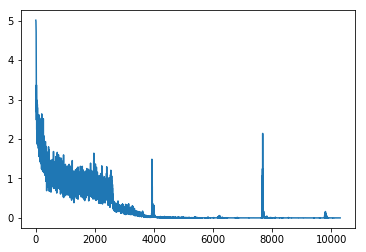

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))